In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import tqdm
import matplotlib.pyplot as plt
from model import FNO1d
from utils import relative_l2_error, PDEDataset

In [2]:
modes = 16
width = 64
fno = FNO1d(modes, width)  # model

# load model weights
fno.load_state_dict(torch.load("models/fno_model.pth", weights_only=True))

RuntimeError: Error(s) in loading state_dict for FNO1d:
	Missing key(s) in state_dict: "spectral_layers.0.batch_norm.inp2scale.weight", "spectral_layers.0.batch_norm.inp2scale.bias", "spectral_layers.0.batch_norm.inp2bias.weight", "spectral_layers.0.batch_norm.inp2bias.bias", "spectral_layers.0.batch_norm.norm.weight", "spectral_layers.0.batch_norm.norm.bias", "spectral_layers.0.batch_norm.norm.running_mean", "spectral_layers.0.batch_norm.norm.running_var", "spectral_layers.1.batch_norm.inp2scale.weight", "spectral_layers.1.batch_norm.inp2scale.bias", "spectral_layers.1.batch_norm.inp2bias.weight", "spectral_layers.1.batch_norm.inp2bias.bias", "spectral_layers.1.batch_norm.norm.weight", "spectral_layers.1.batch_norm.norm.bias", "spectral_layers.1.batch_norm.norm.running_mean", "spectral_layers.1.batch_norm.norm.running_var", "spectral_layers.2.batch_norm.inp2scale.weight", "spectral_layers.2.batch_norm.inp2scale.bias", "spectral_layers.2.batch_norm.inp2bias.weight", "spectral_layers.2.batch_norm.inp2bias.bias", "spectral_layers.2.batch_norm.norm.weight", "spectral_layers.2.batch_norm.norm.bias", "spectral_layers.2.batch_norm.norm.running_mean", "spectral_layers.2.batch_norm.norm.running_var", "spectral_layers.3.batch_norm.inp2scale.weight", "spectral_layers.3.batch_norm.inp2scale.bias", "spectral_layers.3.batch_norm.inp2bias.weight", "spectral_layers.3.batch_norm.inp2bias.bias", "spectral_layers.3.batch_norm.norm.weight", "spectral_layers.3.batch_norm.norm.bias", "spectral_layers.3.batch_norm.norm.running_mean", "spectral_layers.3.batch_norm.norm.running_var", "linear_conv_layers.0.convolution1.weight", "linear_conv_layers.0.convolution1.bias", "linear_conv_layers.0.convolution2.weight", "linear_conv_layers.0.convolution2.bias", "linear_conv_layers.0.batch_norm1.inp2scale.weight", "linear_conv_layers.0.batch_norm1.inp2scale.bias", "linear_conv_layers.0.batch_norm1.inp2bias.weight", "linear_conv_layers.0.batch_norm1.inp2bias.bias", "linear_conv_layers.0.batch_norm1.norm.weight", "linear_conv_layers.0.batch_norm1.norm.bias", "linear_conv_layers.0.batch_norm1.norm.running_mean", "linear_conv_layers.0.batch_norm1.norm.running_var", "linear_conv_layers.0.batch_norm2.inp2scale.weight", "linear_conv_layers.0.batch_norm2.inp2scale.bias", "linear_conv_layers.0.batch_norm2.inp2bias.weight", "linear_conv_layers.0.batch_norm2.inp2bias.bias", "linear_conv_layers.0.batch_norm2.norm.weight", "linear_conv_layers.0.batch_norm2.norm.bias", "linear_conv_layers.0.batch_norm2.norm.running_mean", "linear_conv_layers.0.batch_norm2.norm.running_var", "linear_conv_layers.1.convolution1.weight", "linear_conv_layers.1.convolution1.bias", "linear_conv_layers.1.convolution2.weight", "linear_conv_layers.1.convolution2.bias", "linear_conv_layers.1.batch_norm1.inp2scale.weight", "linear_conv_layers.1.batch_norm1.inp2scale.bias", "linear_conv_layers.1.batch_norm1.inp2bias.weight", "linear_conv_layers.1.batch_norm1.inp2bias.bias", "linear_conv_layers.1.batch_norm1.norm.weight", "linear_conv_layers.1.batch_norm1.norm.bias", "linear_conv_layers.1.batch_norm1.norm.running_mean", "linear_conv_layers.1.batch_norm1.norm.running_var", "linear_conv_layers.1.batch_norm2.inp2scale.weight", "linear_conv_layers.1.batch_norm2.inp2scale.bias", "linear_conv_layers.1.batch_norm2.inp2bias.weight", "linear_conv_layers.1.batch_norm2.inp2bias.bias", "linear_conv_layers.1.batch_norm2.norm.weight", "linear_conv_layers.1.batch_norm2.norm.bias", "linear_conv_layers.1.batch_norm2.norm.running_mean", "linear_conv_layers.1.batch_norm2.norm.running_var", "linear_conv_layers.2.convolution1.weight", "linear_conv_layers.2.convolution1.bias", "linear_conv_layers.2.convolution2.weight", "linear_conv_layers.2.convolution2.bias", "linear_conv_layers.2.batch_norm1.inp2scale.weight", "linear_conv_layers.2.batch_norm1.inp2scale.bias", "linear_conv_layers.2.batch_norm1.inp2bias.weight", "linear_conv_layers.2.batch_norm1.inp2bias.bias", "linear_conv_layers.2.batch_norm1.norm.weight", "linear_conv_layers.2.batch_norm1.norm.bias", "linear_conv_layers.2.batch_norm1.norm.running_mean", "linear_conv_layers.2.batch_norm1.norm.running_var", "linear_conv_layers.2.batch_norm2.inp2scale.weight", "linear_conv_layers.2.batch_norm2.inp2scale.bias", "linear_conv_layers.2.batch_norm2.inp2bias.weight", "linear_conv_layers.2.batch_norm2.inp2bias.bias", "linear_conv_layers.2.batch_norm2.norm.weight", "linear_conv_layers.2.batch_norm2.norm.bias", "linear_conv_layers.2.batch_norm2.norm.running_mean", "linear_conv_layers.2.batch_norm2.norm.running_var", "linear_conv_layers.3.convolution1.weight", "linear_conv_layers.3.convolution1.bias", "linear_conv_layers.3.convolution2.weight", "linear_conv_layers.3.convolution2.bias", "linear_conv_layers.3.batch_norm1.inp2scale.weight", "linear_conv_layers.3.batch_norm1.inp2scale.bias", "linear_conv_layers.3.batch_norm1.inp2bias.weight", "linear_conv_layers.3.batch_norm1.inp2bias.bias", "linear_conv_layers.3.batch_norm1.norm.weight", "linear_conv_layers.3.batch_norm1.norm.bias", "linear_conv_layers.3.batch_norm1.norm.running_mean", "linear_conv_layers.3.batch_norm1.norm.running_var", "linear_conv_layers.3.batch_norm2.inp2scale.weight", "linear_conv_layers.3.batch_norm2.inp2scale.bias", "linear_conv_layers.3.batch_norm2.inp2bias.weight", "linear_conv_layers.3.batch_norm2.inp2bias.bias", "linear_conv_layers.3.batch_norm2.norm.weight", "linear_conv_layers.3.batch_norm2.norm.bias", "linear_conv_layers.3.batch_norm2.norm.running_mean", "linear_conv_layers.3.batch_norm2.norm.running_var". 
	Unexpected key(s) in state_dict: "linear_conv_layers.0.weight", "linear_conv_layers.0.bias", "linear_conv_layers.1.weight", "linear_conv_layers.1.bias", "linear_conv_layers.2.weight", "linear_conv_layers.2.bias", "linear_conv_layers.3.weight", "linear_conv_layers.3.bias". 

In [3]:
BATCH_SIZE = 10

In [4]:
test_data = PDEDataset("../../data/FNO - Wave Equation/test_sol.npy")
test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
fno.eval()
progress_bar = tqdm.tqdm(test_data_loader)

with torch.no_grad():
    test_relative_l2 = 0.0
    for input_batch in progress_bar:
        first = input_batch[:, 0, :]
        target = input_batch[:, -1, :, 0]

        prediction = fno(first).squeeze(-1)

        loss = relative_l2_error(prediction, target)
        test_relative_l2 += loss.item()
    test_relative_l2 /= len(test_data)

test_relative_l2

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 249.86it/s]


0.00865516543854028

In [6]:
# pick 10 random samples and draw prediction and target
samples = test_data[np.random.randint(0, len(test_data), 10)]

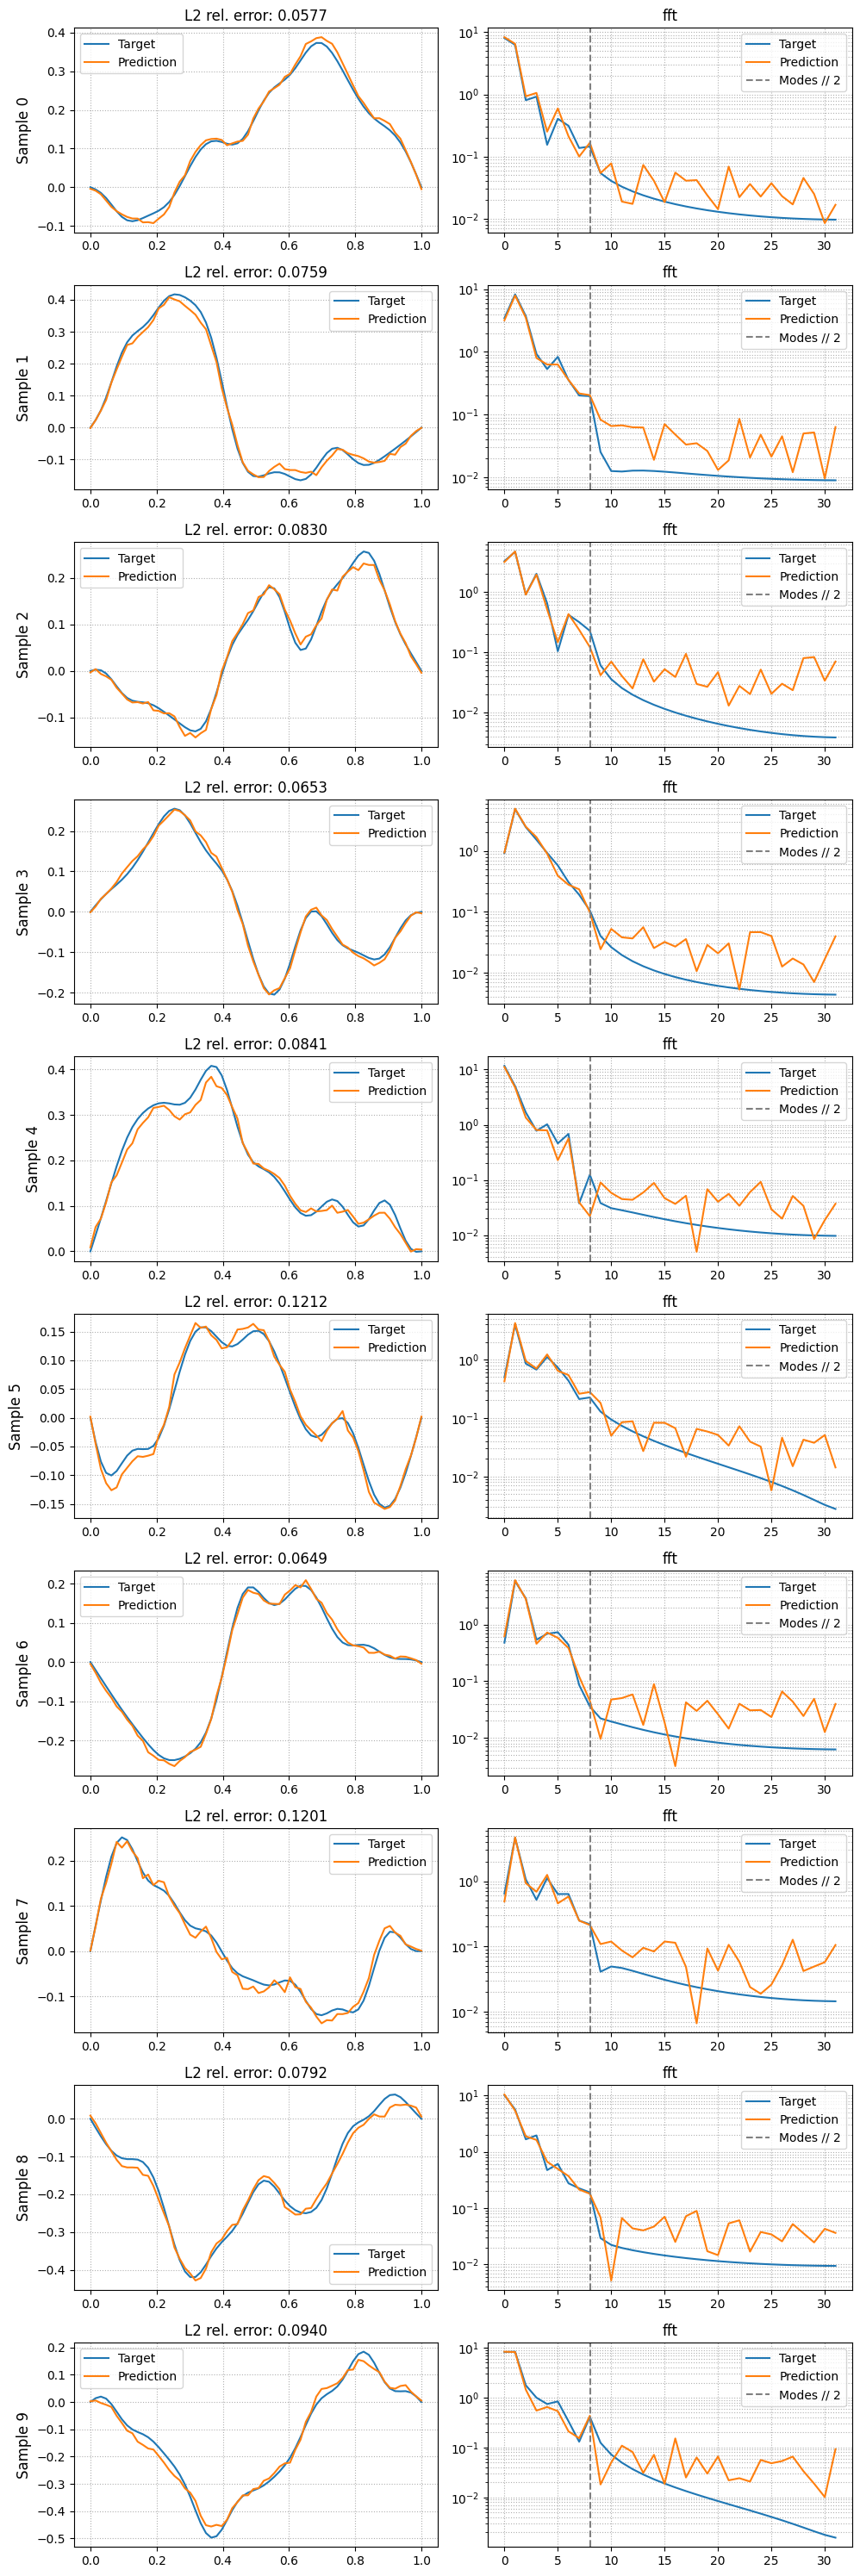

In [7]:
fig, axs = plt.subplots(10, 2, figsize=(10, 30))

fno.eval()
with torch.no_grad():
    for i, (ax_rows, sample) in enumerate(zip(axs, samples)):
        first = sample[0, :].unsqueeze(0)
        target = sample[-1, :, 0].unsqueeze(0)

        prediction = fno(first).squeeze(-1)

        re_l2_error = relative_l2_error(prediction, target)

        ax = ax_rows[0]

        ax.set_ylabel(f"Sample {i}", fontsize=12)

        ax.plot(
            sample[0, :, 1].numpy(),
            target.squeeze(0).numpy(),
            label="Target",
        )
        ax.plot(
            sample[0, :, 1].numpy(),
            prediction.squeeze(0).numpy(),
            label="Prediction",
        )

        ax.set_title(f"L2 rel. error: {re_l2_error:.4f}")

        ax.legend()
        ax.grid(True, which="both", ls=":")

        ax = ax_rows[1]
        ax.set_yscale("log")

        # plot freqiencies spectrum of target and prediction
        target_fft = np.fft.fft(target.squeeze(0).numpy())
        prediction_fft = np.fft.fft(prediction.squeeze(0).numpy())

        ax.plot(
            np.abs(target_fft)[: len(target_fft) // 2],
            label="Target",
        )

        ax.plot(
            np.abs(prediction_fft)[: len(prediction_fft) // 2],
            label="Prediction",
        )

        ax.axvline(modes // 2, color="gray", ls="--", label="Modes // 2")

        ax.set_title("fft")
        ax.legend()
        ax.grid(True, which="both", ls=":")

plt.tight_layout()
plt.show()

In [8]:
def eval_model_on_data_set(model: torch.nn.Module, data_loader: DataLoader):
    model.eval()
    total_relative_error = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in data_loader:
            input = batch[:, 0, :]
            target = batch[:, -1, :, 0]

            pred = model(input).squeeze(-1)
            total_relative_error += relative_l2_error(pred, target).item()
            num_samples += input.size(0)

    return total_relative_error / num_samples

Resolution 32: average relative L2 error: 0.0344
Resolution 64: average relative L2 error: 0.0087
Resolution 96: average relative L2 error: 0.0171
Resolution 128: average relative L2 error: 0.0160


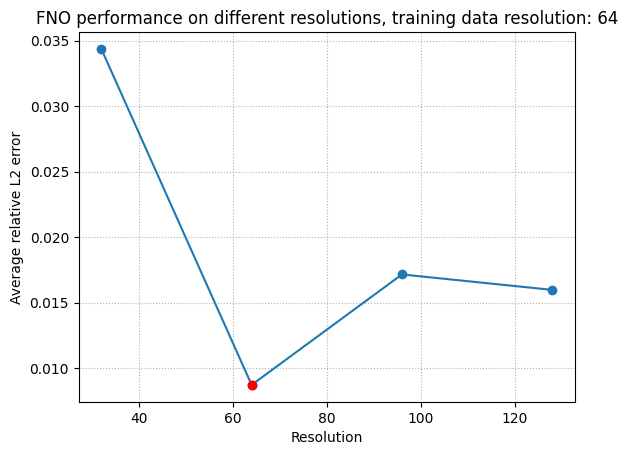

In [9]:
errors = []

for i, n in enumerate([32, 64, 96, 128]):
    test_data = PDEDataset(f"../../data/FNO - Wave Equation/test_sol_res_{n}.npy")
    test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

    test_relative_l2 = eval_model_on_data_set(fno, test_data_loader)
    print(f"Resolution {n}: average relative L2 error: {test_relative_l2:.4f}")

    errors.append(test_relative_l2)


plt.plot([32, 64, 96, 128], errors, marker="o")

# red dot at the resolution of the training data (64)
plt.plot(64, errors[1], marker="o", color="red")

plt.xlabel("Resolution")
plt.ylabel("Average relative L2 error")
plt.title("FNO performance on different resolutions, training data resolution: 64")
plt.grid(True, which="both", ls=":")
plt.show()


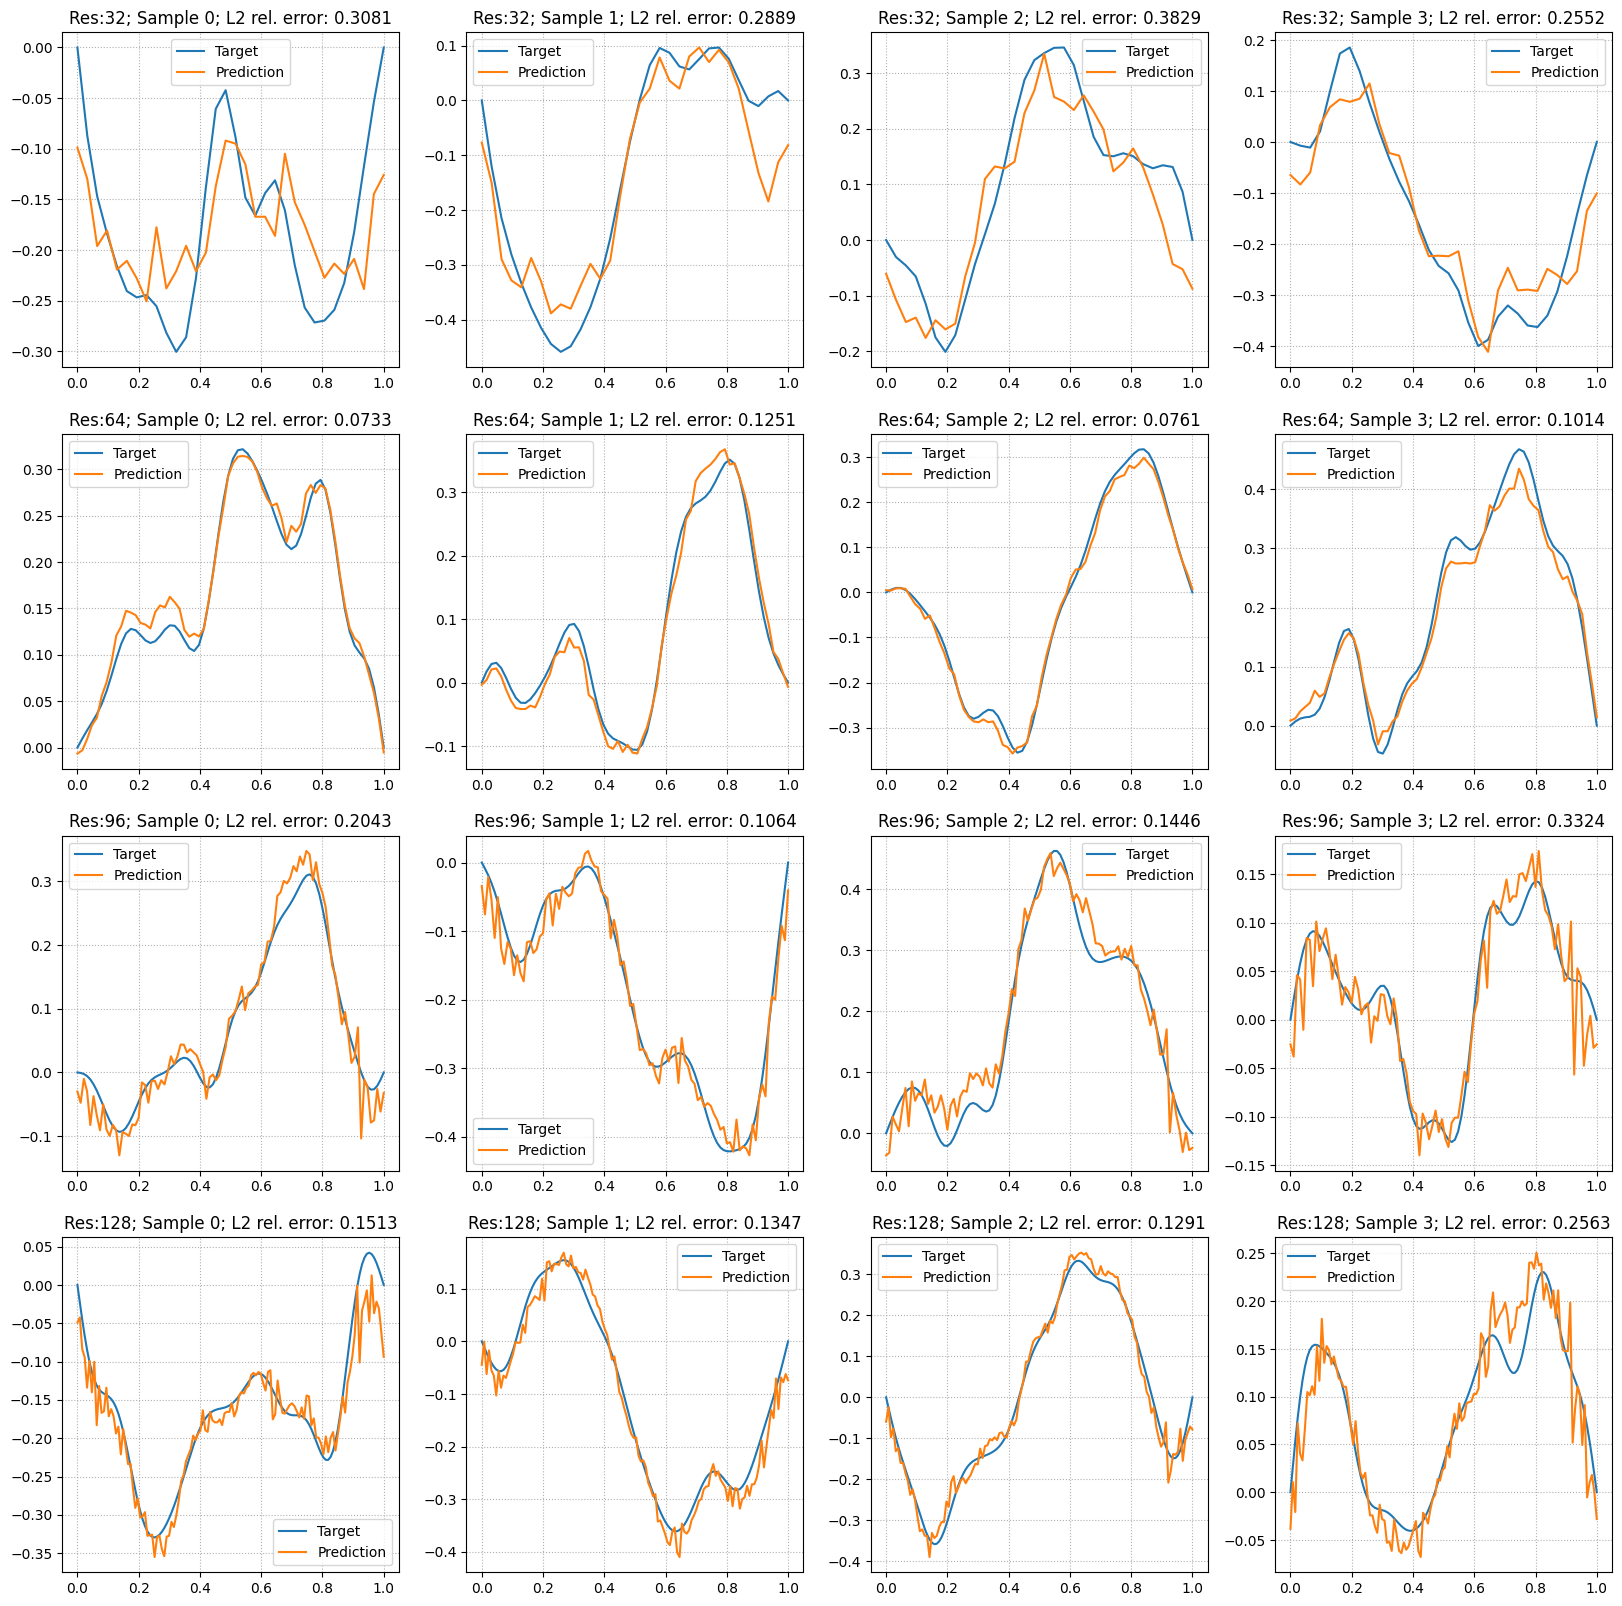

In [10]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for i, n in enumerate([32, 64, 96, 128]):
    test_data = PDEDataset(f"../../data/FNO - Wave Equation/test_sol_res_{n}.npy")
    test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

    # pick N samples
    N = 4
    samples = test_data[np.random.randint(0, len(test_data), N)]

    with torch.no_grad():
        for j, sample in enumerate(samples):
            input = sample[0, :].unsqueeze(0)
            target = sample[-1, :, 0].unsqueeze(0)

            prediction = fno(input).squeeze(-1)

            re_l2_error = relative_l2_error(prediction, target)

            ax = axs[i, j]

            ax.plot(
                sample[0, :, 1].numpy(),
                target.squeeze(0).numpy(),
                label="Target",
            )
            ax.plot(
                sample[0, :, 1].numpy(),
                prediction.squeeze(0).numpy(),
                label="Prediction",
            )
            ax.set_title(f"Res:{n}; Sample {j}; L2 rel. error: {re_l2_error:.4f}")

            ax.legend()
            ax.grid(True, which="both", ls=":")